In [ ]:
# --- Offline simulation: probability of each action over 5 rounds (single slot) ---

from typing import Any, Dict, Iterable, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from obp.dataset import OpenBanditDataset
from plotly.subplots import make_subplots

SEED = 7
rng = np.random.RandomState(SEED)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


### Helper Functions

In [ ]:
def exact_pmf_one_update(K: int, updated_arm: int, reward: int):
    """
    Closed-form TS selection probabilities when all arms start Beta(1,1),
    and exactly one arm is updated once at this position (no MC).
    """
    p = np.empty(K, dtype=float)
    if reward == 1:
        p_updated = 2.0 / (K + 1.0)              # updated arm
        p_others  = 1.0 / (K + 1.0)              # every other arm
    else:
        p_updated = 2.0 / (K * (K + 1.0))        # updated arm
        p_others  = (1.0 - p_updated) / (K - 1.) # spread remainder evenly
    p.fill(p_others)
    p[updated_arm] = p_updated
    return p

def make_probs_df(round_num: int, alpha, beta, pmf_by_pos):
    """Build a wide DataFrame for a given round with selection probs and α/β per position."""
    rows = []
    for a in range(n_actions):
        row = {"round": round_num, "action": a}
        for pos in positions:
            row[f"p_pos{pos}"]     = pmf_by_pos[pos][a]
            row[f"alpha_pos{pos}"] = alpha[pos][a]
            row[f"beta_pos{pos}"]  = beta[pos][a]
        rows.append(row)
    return pd.DataFrame(rows)

def plot_empirical_means(
    df: pd.DataFrame,
    group_col: str = "action",
    value_col: str = "reward",
    title: str | None = None,
    height: int = 500,
):
    """
    Plot empirical mean (e.g. CTR) of a value_col grouped by group_col.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain group_col and value_col.
    group_col : str, default="action"
        Column to group by (x-axis).
    value_col : str, default="reward"
        Column to average (y-axis).
    title : str, optional
        Plot title (default auto-generated).
    height : int, default=500
        Plot height in pixels.

    Returns
    -------
    fig : plotly.graph_objects.Figure
        The bar chart figure.
    """
    # compute means
    means = df.groupby(group_col)[value_col].mean().reset_index()
    means.rename(columns={value_col: f"mean_{value_col}"}, inplace=True)

    # plot
    fig = px.bar(
        means,
        x=group_col,
        y=f"mean_{value_col}",
        labels={group_col: group_col.capitalize(), f"mean_{value_col}": f"Mean {value_col}"},
        title=title or f"Empirical mean of {value_col} by {group_col}",
    )

    # beautify x-axis ticks
    fig.update_layout(
        xaxis=dict(
            tickmode="array",
            tickvals=means[group_col],
            ticktext=[str(v) for v in means[group_col]],
            title=group_col.capitalize(),
        ),
        yaxis=dict(title=f"Mean {value_col}"),
        template="plotly_white",
        height=height,
    )
    return fig


def plot_pmf_compare_by_position(
    pmf_round_A: dict[int, np.ndarray],
    pmf_round_B: dict[int, np.ndarray],
    positions: list[int],
    n_actions: int,
    title: str = "Selection probabilities by position",
    round_labels: tuple[str, str] = ("Round 0 (uniform)", "Round 1 (updated)"),
    colors: tuple[str, str] = ("steelblue", "darkorange"),
    height_per_row: int = 300,
) -> go.Figure:
    fig = make_subplots(
        rows=len(positions), cols=1, shared_xaxes=False,
        subplot_titles=[f"Position {p}" for p in positions],
        vertical_spacing=0.08
    )

    xs = np.arange(n_actions)
    tick_vals = xs
    tick_txt  = [str(a) for a in xs]

    for i, pos in enumerate(positions, start=1):
        yA = pmf_round_A[pos]
        yB = pmf_round_B[pos]
        ymax = float(max(yA.max(), yB.max())) * 1.25 if (yA.size and yB.size) else 0.02

        fig.add_trace(
            go.Bar(
                x=xs, y=yA, name=round_labels[0],
                marker=dict(color=colors[0]),
                opacity=0.6, legendgroup="roundA",
                showlegend=(i == 1),
                customdata=np.column_stack([np.full(n_actions, pos)]),
                hovertemplate=(
                    "Position: %{customdata[0]}<br>"
                    "Action: %{x}<br>"
                    f"{round_labels[0]}<br>P: %{{y:.6f}}<extra></extra>"
                ),
            ),
            row=i, col=1
        )
        fig.add_trace(
            go.Bar(
                x=xs, y=yB, name=round_labels[1],
                marker=dict(color=colors[1]),
                opacity=0.85, legendgroup="roundB",
                showlegend=(i == 1),
                customdata=np.column_stack([np.full(n_actions, pos)]),
                hovertemplate=(
                    "Position: %{customdata[0]}<br>"
                    "Action: %{x}<br>"
                    f"{round_labels[1]}<br>P: %{{y:.6f}}<extra></extra>"
                ),
            ),
            row=i, col=1
        )

        fig.update_yaxes(title_text="P(action selected)", range=[0, ymax], row=i, col=1)
        fig.update_xaxes(
            tickmode="array", tickvals=tick_vals, ticktext=tick_txt,
            showticklabels=True, ticks="outside",
            title_text=f"Action ID (0–{n_actions-1})" if i == len(positions) else "",
            row=i, col=1
        )

    fig.update_layout(
        title=title, barmode="group", bargap=0.15,
        template="plotly_white", height=height_per_row * len(positions) + 120,
    )
    return fig

from typing import Iterable, Dict, Any, Optional, Tuple
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots


class ThompsonSlateTracker:
    def __init__(
        self,
        df: pd.DataFrame,
        n_actions: int,
        positions: Iterable[int] = (0, 1, 2),
        seed: int = 7,
        factorize_by_position: bool = True,  # False => vanilla TS
    ):
        """
        df: DataFrame with columns ['action','position','reward','pscore']
        n_actions: number of actions (e.g., 80)
        positions: iterable of slot indices (only used if factorize_by_position=True)
        factorize_by_position: if True -> one bandit per position; else -> single vanilla bandit
        """
        self.df = df
        self.n_actions = int(n_actions)
        self.factorize = bool(factorize_by_position)
        self.rng = np.random.RandomState(seed)

        if self.factorize:
            # independent bandit per position
            self.positions = tuple(positions)
            self.bandit_keys = list(self.positions)  # rows to plot
        else:
            # single bandit that ignores position
            self.positions = tuple(positions)  # kept for compatibility, not used in updates
            self.bandit_keys = ["all"]  # one row to plot

        # priors α,β per bandit_key
        self.alpha = {k: np.ones(self.n_actions, dtype=float) for k in self.bandit_keys}
        self.beta = {k: np.ones(self.n_actions, dtype=float) for k in self.bandit_keys}

        # history
        self.round = 0
        self.pmfs: Dict[int, Dict[Any, np.ndarray]] = {}     # round -> {bandit_key -> np.array(n_actions)}
        self.samples: Dict[int, pd.DataFrame] = {}           # round -> DataFrame of sampled rows

        # round 0 PMF snapshot (uniform)
        pmf0 = {k: np.full(self.n_actions, 1.0 / self.n_actions) for k in self.bandit_keys}
        self.pmfs[0] = pmf0
        self.samples[0] = pd.DataFrame(columns=["action", "position", "reward", "pscore"])

    # ---------- PMF backends ----------
    @staticmethod
    def _pmf_exact_one_update(K: int, updated_arm: int, reward: int):
        """Exact closed-form PMF when starting from Beta(1,1) and exactly one arm updated once."""
        p = np.empty(K, dtype=float)
        if reward == 1:
            p_updated = 2.0 / (K + 1.0)
            p_others = 1.0 / (K + 1.0)
        else:
            p_updated = 2.0 / (K * (K + 1.0))
            p_others = (1.0 - p_updated) / (K - 1.0)
        p.fill(p_others)
        p[updated_arm] = p_updated
        return p

    @staticmethod
    def _pmf_mc(alpha_vec, beta_vec, n_sim=200_000, rng=None):
        """Monte Carlo PMF: P(action = argmax)."""
        rng = np.random.RandomState() if rng is None else rng
        K = len(alpha_vec)
        samples = rng.beta(alpha_vec[None, :], beta_vec[None, :], size=(n_sim, K))
        winners = samples.argmax(axis=1)
        counts = np.bincount(winners, minlength=K)
        return counts / counts.sum()

    def _can_use_exact(self, key) -> Tuple[bool, Optional[int], Optional[int]]:
        """Exact valid iff all (α,β)=(1,1) except possibly one arm with (2,1) or (1,2)."""
        a = self.alpha[key]
        b = self.beta[key]
        mask_11 = (a == 1) & (b == 1)
        if mask_11.all():
            return True, None, None
        idx = np.where(~mask_11)[0]
        if len(idx) != 1:
            return False, None, None
        j = int(idx[0])
        pair = (a[j], b[j])
        if pair == (2, 1):
            return True, j, 1
        if pair == (1, 2):
            return True, j, 0
        return False, None, None

    # ---------- Sampling / updates ----------
    def _sample_batch(self, random_state=None) -> pd.DataFrame:
        """
        Returns sampled rows used for this round:
          - factorized: one row per position
          - vanilla:    a single row from the entire df
        """
        if self.factorize:
            return (
                self.df.groupby("position", group_keys=False)
                .apply(lambda x: x.sample(1, random_state=random_state))
                .reset_index(drop=True)
            )
        else:
            return self.df.sample(1, random_state=random_state).reset_index(drop=True)

    def apply_updates(self, sampled_rows: pd.DataFrame):
        """Update α/β from sampled rows."""
        for _, r in sampled_rows.iterrows():
            a = int(r["action"])
            y = int(r["reward"])
            if self.factorize:
                key = int(r["position"])
            else:
                key = "all"  # ignore position
            self.alpha[key][a] += y
            self.beta[key][a] += (1 - y)

    def snapshot_pmfs(self, use_mc_if_needed=True, n_sim=200_000):
        """Compute PMF for each bandit_key; store under current round."""
        pmf = {}
        for key in self.bandit_keys:
            ok_exact, idx, rew = self._can_use_exact(key)
            if ok_exact:
                if idx is None:
                    pmf[key] = np.full(self.n_actions, 1.0 / self.n_actions, dtype=float)
                else:
                    pmf[key] = self._pmf_exact_one_update(self.n_actions, idx, rew)
            else:
                if not use_mc_if_needed:
                    raise RuntimeError(
                        f"Exact closed-form not valid for '{key}' after round {self.round}. "
                        "Set use_mc_if_needed=True to compute PMFs."
                    )
                pmf[key] = self._pmf_mc(self.alpha[key], self.beta[key], n_sim=n_sim, rng=self.rng)
        self.pmfs[self.round] = pmf

    def next_round(self, random_state=None, use_mc_if_needed=True, n_sim=200_000) -> pd.DataFrame:
        """Advance one round: sample, update, snapshot."""
        self.round += 1
        samp = self._sample_batch(random_state=random_state)
        self.samples[self.round] = samp
        self.apply_updates(samp)
        self.snapshot_pmfs(use_mc_if_needed=use_mc_if_needed, n_sim=n_sim)
        return samp

    # ---------- Plot ----------
    def _round_picks_by_key(self, round_id: int):
        """
        Return a dict: key -> {'action': int, 'reward': int} for that round's sampled row(s).
        - factorized: one per position key
        - vanilla:    one under key 'all'
        If round_id == 0 (no samples), returns {}.
        """
        if round_id not in self.samples or self.samples[round_id].empty:
            return {}
        picks = {}
        df_s = self.samples[round_id]
        if self.factorize:
            for _, r in df_s.iterrows():
                pos = int(r["position"])
                picks[pos] = {"action": int(r["action"]), "reward": int(r["reward"])}
        else:
            r = df_s.iloc[0]
            picks["all"] = {"action": int(r["action"]), "reward": int(r["reward"])}
        return picks

    def plot_compare(
        self,
        round_a: int,
        round_b: int,
        height=900,
        title=None,
        show_picks: bool = True,
        pick_marker_a=dict(color="crimson", symbol="triangle-up", size=12),
        pick_marker_b=dict(color="forestgreen", symbol="diamond", size=11),
    ):
        """Grouped bars comparing PMFs of two rounds; optionally highlight sampled picks."""
        if round_a not in self.pmfs or round_b not in self.pmfs:
            raise KeyError("Requested rounds not in history. Call next_round() first.")

        pmf_a = self.pmfs[round_a]
        pmf_b = self.pmfs[round_b]
        n_actions = self.n_actions
        row_keys = self.bandit_keys  # ['all'] or [positions...]

        # gather picks (if any) for each round
        picks_a = self._round_picks_by_key(round_a)
        picks_b = self._round_picks_by_key(round_b)

        fig = make_subplots(
            rows=len(row_keys),
            cols=1,
            shared_xaxes=False,
            subplot_titles=[f"Position {k}" if k != "all" else "Vanilla TS" for k in row_keys],
            vertical_spacing=0.08,
        )

        xs = np.arange(n_actions)
        labels = [str(a) for a in xs]

        for i, key in enumerate(row_keys, start=1):
            yA = pmf_a[key]
            yB = pmf_b[key]
            ymax = float(max(yA.max(), yB.max())) * 1.25

            # Bars for the two rounds
            fig.add_bar(
                x=xs,
                y=yA,
                name=f"Round {round_a}",
                marker_color="steelblue",
                opacity=0.6,
                showlegend=(i == 1),
                row=i,
                col=1,
            )
            fig.add_bar(
                x=xs,
                y=yB,
                name=f"Round {round_b}",
                marker_color="darkorange",
                opacity=0.85,
                showlegend=(i == 1),
                row=i,
                col=1,
            )

            # Optional markers for the sampled pick(s) that updated the round
            if show_picks:
                # Round A pick on its PMF
                if key in picks_a:
                    a_pick = picks_a[key]["action"]
                    r_pick = picks_a[key]["reward"]
                    fig.add_trace(
                        go.Scatter(
                            x=[a_pick],
                            y=[yA[a_pick]],
                            mode="markers",
                            marker=pick_marker_a,
                            name=f"Picked (r={round_a})",
                            showlegend=(i == 1),
                            hovertemplate=(
                                f"Round {round_a}<br>"
                                f"{'Position' if key!='all' else 'Bandit'}: {key}<br>"
                                "Action: %{x}<br>"
                                "P: %{y:.6f}<br>"
                                f"Reward: {r_pick}<extra></extra>"
                            ),
                        ),
                        row=i,
                        col=1,
                    )

                # Round B pick on its PMF
                if key in picks_b:
                    b_pick = picks_b[key]["action"]
                    r_pick = picks_b[key]["reward"]
                    fig.add_trace(
                        go.Scatter(
                            x=[b_pick],
                            y=[yB[b_pick]],
                            mode="markers",
                            marker=pick_marker_b,
                            name=f"Picked (r={round_b})",
                            showlegend=(i == 1),
                            hovertemplate=(
                                f"Round {round_b}<br>"
                                f"{'Position' if key!='all' else 'Bandit'}: {key}<br>"
                                "Action: %{x}<br>"
                                "P: %{y:.6f}<br>"
                                f"Reward: {r_pick}<extra></extra>"
                            ),
                        ),
                        row=i,
                        col=1,
                    )

            # Axes
            fig.update_yaxes(title_text="P(select)", range=[0, ymax], row=i, col=1)
            fig.update_xaxes(
                tickmode="array",
                tickvals=xs,
                ticktext=labels,
                title_text=f"Action ID (0–{n_actions-1})" if i == len(row_keys) else "",
                row=i,
                col=1,
            )

        ttl = title or (
            f"{'Position-aware' if self.factorize else 'Vanilla'} Thompson Sampling: "
            f"Round {round_a} vs Round {round_b}"
        )
        fig.update_layout(
            title=ttl,
            barmode="group",
            bargap=0.15,
            template="plotly_white",
            height=max(350 * len(row_keys), 450),
        )
        fig.show()

    # ---------- small conveniences ----------
    def get_pmf(self, round_id: Optional[int] = None) -> Dict[Any, np.ndarray]:
        """Return PMFs for a given round (default: current)."""
        rid = self.round if round_id is None else round_id
        if rid not in self.pmfs:
            raise KeyError(f"No PMF stored for round {rid}.")
        return self.pmfs[rid]

    def rollout(self, n_rounds: int, **kwargs) -> None:
        """Run multiple rounds back-to-back (stores samples/pmfs as usual)."""
        for _ in range(int(n_rounds)):
            self.next_round(**kwargs)

    def reset(self):
        """Reset posteriors and history to round 0 (uniform)."""
        for k in self.bandit_keys:
            self.alpha[k].fill(1.0)
            self.beta[k].fill(1.0)
        self.round = 0
        self.pmfs = {0: {k: np.full(self.n_actions, 1.0 / self.n_actions) for k in self.bandit_keys}}
        self.samples = {0: pd.DataFrame(columns=["action", "position", "reward", "pscore"])}




def plot_empirical_ctr_by_position(
    df: pd.DataFrame,
    positions: list[int] | None = None,
    n_actions: int | None = None,
    height_per_row: int = 300,
    title: str = "Empirical CTR per Action (split by Position)",
) -> go.Figure:
    """
    Make a multi-row bar chart where each row is a position and bars show
    empirical CTR (= mean reward) per action for that position.

    Parameters
    ----------
    df : DataFrame with columns ['action','position','reward', ...]
    positions : list[int] | None
        Which positions to plot. Defaults to all positions present in df (sorted).
    n_actions : int | None
        If given, ensures x-axis shows 0..n_actions-1 and fills missing actions with CTR=0.
        If None, uses only the actions present for each position.
    height_per_row : int
        Height per subplot row.
    title : str
        Figure title.

    Returns
    -------
    fig : plotly.graph_objects.Figure
    """
    # 1) compute mean reward per (position, action)
    ctr = (
        df.groupby(["position", "action"])["reward"]
          .mean()
          .reset_index(name="ctr")
    )

    # positions to plot
    if positions is None:
        positions = sorted(df["position"].unique().tolist())

    # 2) build subplots
    fig = make_subplots(
        rows=len(positions), cols=1, shared_xaxes=False,
        subplot_titles=[f"Position {p}" for p in positions],
        vertical_spacing=0.08
    )

    # helper for x-axis domain and filling
    def _prep_pos_slice(pos: int):
        sub = ctr[ctr["position"] == pos][["action", "ctr"]].copy()
        if n_actions is not None:
            # fill missing actions with 0 CTR to show full 0..n_actions-1
            all_actions = pd.DataFrame({"action": np.arange(n_actions)})
            sub = all_actions.merge(sub, on="action", how="left").fillna({"ctr": 0.0})
        sub.sort_values("action", inplace=True)
        return sub

    # 3) per-row bars + axes
    for i, pos in enumerate(positions, start=1):
        sub = _prep_pos_slice(pos)
        xs = sub["action"].to_numpy()
        ys = sub["ctr"].to_numpy()
        ymax = float(ys.max() * 1.25 if ys.size else 0.02)

        fig.add_bar(
            x=xs, y=ys,
            name=f"Pos {pos}",
            marker_color="steelblue",
            showlegend=False,
            row=i, col=1
        )
        fig.update_yaxes(title_text="Empirical CTR", range=[0, ymax], row=i, col=1)
        fig.update_xaxes(
            title_text=f"Action ID (0–{int(xs.max())})" if i == len(positions) else "",
            tickmode="array",
            tickvals=xs,
            ticktext=[str(a) for a in xs],
            row=i, col=1
        )

    fig.update_layout(
        title=title,
        template="plotly_white",
        height=height_per_row * len(positions) + 120
    )
    return fig




def plot_ctr_grouped_by_action_position_discrete(
    df: pd.DataFrame,
    positions=(0, 1, 2),
    title="Empirical CTR per Action by Position (discrete, grouped)"
) -> go.Figure:
    # mean CTR per (position, action) and fill missing combos with 0
    actions_all = np.sort(df["action"].unique())
    ctr = (df.groupby(["position", "action"])["reward"]
             .mean()
             .reset_index(name="ctr"))
    full = (pd.MultiIndex.from_product([positions, actions_all],
            names=["position", "action"])
            .to_frame(index=False))
    ctr_full = (full.merge(ctr, on=["position", "action"], how="left")
                    .fillna({"ctr": 0.0}))

    # pivot to wide: rows = action, cols = position (ensures discrete series)
    wide = ctr_full.pivot(index="action", columns="position", values="ctr").reindex(actions_all).fillna(0.0)

    # build grouped bars (one trace per discrete position)
    fig = go.Figure()
    for pos in positions:
        y = wide[pos].to_numpy() if pos in wide.columns else np.zeros(len(wide))
        fig.add_bar(
            name=f"Position {pos}",
            x=wide.index.to_numpy(),
            y=y,
            offsetgroup=str(pos),  # guarantees side-by-side (not stacked/overlapped)
            legendgroup=str(pos),
        )

    fig.update_layout(
        title=title,
        barmode="group",          # grouped (not stacked)
        bargap=0.15,
        bargroupgap=0.05,
        template="plotly_white",
        xaxis=dict(
            title="Action ID",
            tickmode="array",
            tickvals=actions_all,
            ticktext=[str(a) for a in actions_all],
        ),
        yaxis=dict(title="Empirical CTR"),
        legend_title_text="Position",
        height=600
    )
    return fig

### Load the data

In [26]:

# --- Load OBD (Random / all as example) ---
ds = OpenBanditDataset(behavior_policy="random", campaign="all")
bf = ds.obtain_batch_bandit_feedback()

print("bandit_feedback keys:", bf.keys())
print(f"Rounds: {bf['n_rounds']:,} | n_actions: {bf['n_actions']} | len_list: {ds.len_list}")

# Build a DataFrame for convenience
df = pd.DataFrame({
    "action": bf["action"],
    "position": bf["position"],
    "reward": bf["reward"],
    "pscore": bf["pscore"],
})

df.head()

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.


bandit_feedback keys: dict_keys(['n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])
Rounds: 10,000 | n_actions: 80 | len_list: 3


,action,position,reward,pscore
0,14,2,0,0.0125
1,14,2,0,0.0125
2,27,2,0,0.0125
3,48,1,0,0.0125
4,36,1,0,0.0125


In [27]:
df.shape

(10000, 4)

In [28]:
df.groupby("action")["reward"].mean()

action
0     0.000000
1     0.006250
2     0.000000
3     0.007937
4     0.000000
        ...   
75    0.000000
76    0.000000
77    0.000000
78    0.000000
79    0.000000
Name: reward, Length: 80, dtype: float64

In [29]:

# For CTR per action (your case)
fig = plot_empirical_means(df, group_col="action", value_col="reward", title="Empirical CTR per Action")
fig.show()

# For reward by position
fig2 = plot_empirical_means(df, group_col="position", value_col="reward", title="CTR per Position")
fig2.show()

In [78]:
# three rows (pos 0,1,2), actions limited to those present in df
fig = plot_empirical_ctr_by_position(df, positions=[0,1,2])
fig.show()

# if you want to force showing all actions 0..79 on each row (missing CTRs -> 0)
fig_full = plot_empirical_ctr_by_position(df, positions=[0,1,2], n_actions=80)
fig_full.show()

In [85]:
fig = plot_ctr_grouped_by_action_position_discrete(df)
fig.show()

### Every action being equally likely of being chosen

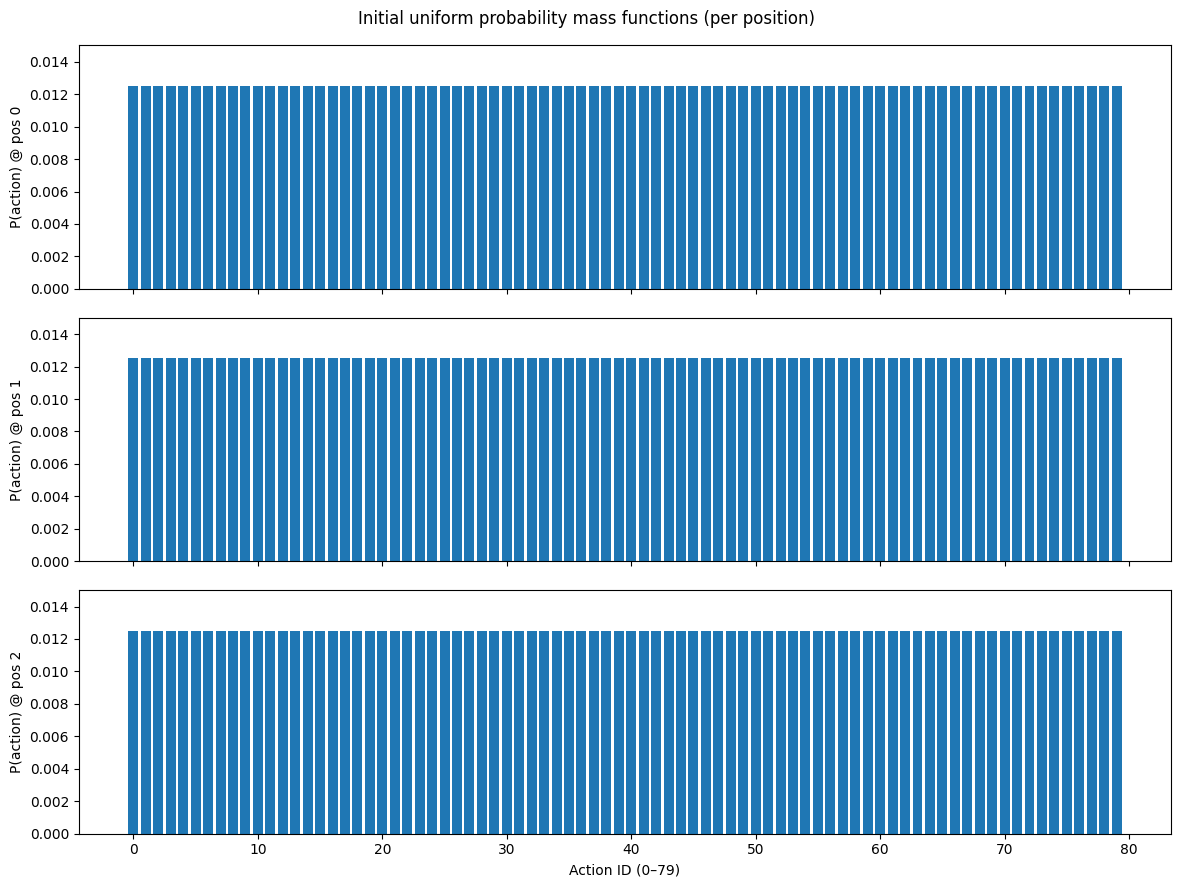

In [30]:
def plot_position_pmfs(pmfs, title="Probability mass functions per position", show=False):

    positions = list(pmfs.keys())
    n_actions = len(next(iter(pmfs.values())))
    fig, axes = plt.subplots(len(positions), 1, figsize=(12, 3*len(positions)), sharex=True)
    if len(positions) == 1:
        axes = [axes]

    for pos, ax in zip(positions, axes):
        ax.bar(np.arange(n_actions), pmfs[pos])
        ax.set_ylabel(f"P(action) @ pos {pos}")
        ax.set_ylim(0, pmfs[pos].max() * 1.2)

    axes[-1].set_xlabel(f"Action ID (0–{n_actions-1})")
    fig.suptitle(title)
    plt.tight_layout()
    if show:
        plt.show()
    return fig


n_actions = bf["n_actions"]   # 80
positions = [0, 1, 2]

# Uniform PMFs for each position
pmfs = {pos: np.ones(n_actions) / n_actions for pos in positions}

fig = plot_position_pmfs(pmfs, title="Initial uniform probability mass functions (per position)")

# Vanilla TS (ignores position)

### Position-Agnostic Vanilla TS with one hop

In [42]:
# create tracker (vanilla TS, no per-position separation)
tracker = ThompsonSlateTracker(
    df=df,
    n_actions=bf["n_actions"],
    positions=[0, 1, 2],      # passed but ignored since factorize_by_position=False
    seed=SEED,
    factorize_by_position=False
)

# round 0 is already uniform
print("PMF round 0 (first 10 probs):", tracker.get_pmf(0)["all"][:10])

# advance one round
samp1 = tracker.next_round(random_state=7, use_mc_if_needed=False)
print("Round 1 sample:\n", samp1)
display(samp1)

# compare round 0 vs round 1
tracker.plot_compare(0, 1, title="Vanilla TS — Round 0 vs Round 1", show_picks=True)

PMF round 0 (first 10 probs): [0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125]
Round 1 sample:
    action  position  reward  pscore
0      17         1       0  0.0125


,action,position,reward,pscore
0,17,1,0,0.0125


### Position-Aware Vanilla TS with one hop

In [41]:
# create tracker (position-aware TS: one bandit per slot)
tracker = ThompsonSlateTracker(
    df=df,
    n_actions=bf["n_actions"],
    positions=[0, 1, 2],     # now actually used
    seed=SEED,
    factorize_by_position=True
)

# round 0 = uniform per position
for pos, pmf in tracker.get_pmf(0).items():
    print(f"PMF round 0 @ position {pos} (first 5 probs): {pmf[:5]}")

# advance one round: samples one row per position
samp1 = tracker.next_round(random_state=7, use_mc_if_needed=False)
print("Round 1 samples:\n", samp1)

display(samp1)

# plot comparison
tracker.plot_compare(0, 1, title="Position-aware TS — Round 0 vs Round 1", show_picks=True)


PMF round 0 @ position 0 (first 5 probs): [0.0125 0.0125 0.0125 0.0125 0.0125]
PMF round 0 @ position 1 (first 5 probs): [0.0125 0.0125 0.0125 0.0125 0.0125]
PMF round 0 @ position 2 (first 5 probs): [0.0125 0.0125 0.0125 0.0125 0.0125]
Round 1 samples:
    action  position  reward  pscore
0      66         0       0  0.0125
1      78         1       0  0.0125
2       1         2       0  0.0125


,action,position,reward,pscore
0,66,0,0,0.0125
1,78,1,0,0.0125
2,1,2,0,0.0125


### Position Aware Vanilla Thompson Sampling N round (1-100)

In [64]:
import pandas as pd
import numpy as np

def pmf_history_to_df(tracker):
    """
    Flatten tracker.pmfs (dict: round -> {key -> np.array(n_actions)})
    into a tidy DataFrame with columns:
      round, bandit_key, action, p_select
    """
    recs = []
    for r, pmf_dict in tracker.pmfs.items():
        for key, vec in pmf_dict.items():
            for a, p in enumerate(np.asarray(vec)):
                recs.append({"round": r, "bandit_key": key, "action": a, "p_select": float(p)})
    return pd.DataFrame(recs)

def picks_history_to_df(tracker):
    """
    Flatten tracker.samples (dict: round -> DataFrame of sampled rows)
    into a tidy DataFrame with columns:
      round, bandit_key, action, reward, position, pscore
    For vanilla TS, bandit_key is 'all'.
    For factorized mode, bandit_key equals position.
    """
    recs = []
    for r, df_s in tracker.samples.items():
        if df_s is None or df_s.empty or r == 0:
            continue
        if tracker.factorize:
            for _, row in df_s.iterrows():
                recs.append({
                    "round": r,
                    "bandit_key": int(row["position"]),
                    "position": int(row["position"]),
                    "action": int(row["action"]),
                    "reward": int(row["reward"]),
                    "pscore": float(row["pscore"]),
                })
        else:
            row = df_s.iloc[0]
            recs.append({
                "round": r,
                "bandit_key": "all",
                "position": int(row["position"]),
                "action": int(row["action"]),
                "reward": int(row["reward"]),
                "pscore": float(row["pscore"]),
            })
    return pd.DataFrame(recs)


In [60]:
df_picks

,round,bandit_key,position,action,reward,pscore
0,1,0,0,66,0,0.0125
1,1,1,1,78,0,0.0125
2,1,2,2,1,0,0.0125
3,2,0,0,66,0,0.0125
4,2,1,1,78,0,0.0125
...,...,...,...,...,...,...
295,99,1,1,78,0,0.0125
296,99,2,2,1,0,0.0125
297,100,0,0,66,0,0.0125
298,100,1,1,78,0,0.0125


In [63]:
df_picks[df_picks["round"] == 2]

,round,bandit_key,position,action,reward,pscore
3,2,0,0,66,0,0.0125
4,2,1,1,78,0,0.0125
5,2,2,2,1,0,0.0125


In [61]:
pmf_wide_r1

action,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
bandit_key,,,,,,,,,,,,,,,,,,,,,
0,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,...,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654
1,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,...,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,0.000309,0.012654
2,0.012654,0.000309,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,...,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654,0.012654


In [62]:
pmf_wide_r100

action,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
bandit_key,,,,,,,,,,,,,,,,,,,,,
0,0.0135,0.0149,0.0127,0.0127,0.0143,0.0115,0.0116,0.0125,0.0123,0.0123,...,0.0136,0.0133,0.0133,0.0098,0.0128,0.0135,0.0146,0.0129,0.0125,0.0121
1,0.0128,0.0110,0.0131,0.0131,0.0140,0.0104,0.0129,0.0122,0.0124,0.0125,...,0.0118,0.0131,0.0133,0.0113,0.0140,0.0117,0.0113,0.0122,0.0000,0.0147
2,0.0134,0.0000,0.0131,0.0122,0.0112,0.0152,0.0115,0.0131,0.0125,0.0149,...,0.0123,0.0133,0.0129,0.0128,0.0137,0.0125,0.0144,0.0137,0.0117,0.0134


In [75]:
### Make sure you leave rollout random state as None, otherwise every time you sample you'll get the exact same set of actions 

In [73]:
# --- Position-aware TS over 100 rounds; show Round 1 vs Round 100 ---

# fresh tracker
tracker = ThompsonSlateTracker(
    df=df,
    n_actions=bf["n_actions"],
    positions=[0, 1, 2],
    seed=7,
    factorize_by_position=True,   # position-aware
)

# Round 0 -> Round 1 (exact closed-form is valid, so keep MC off)
samp1 = tracker.next_round(random_state=SEED, use_mc_if_needed=False)
print("Round 1 samples:\n", samp1)

# Rounds 2..100 (now exact may not apply; allow MC to compute PMFs)
# Tip: random_state=None => fresh randomness each round
tracker.rollout(
    n_rounds=99,                  # advances from current round=1 to round=100
    random_state=None,
    use_mc_if_needed=True,
    n_sim=10_000                  # adjust for speed/variance
)

# Plot Round 1 vs Round 100 with picks highlighted
tracker.plot_compare(
    round_a=1,
    round_b=100,
    title="Position-aware TS — Round 1 vs Round 100",
    show_picks=True
)

Round 1 samples:
    action  position  reward  pscore
0      66         0       0  0.0125
1      78         1       0  0.0125
2       1         2       0  0.0125


In [76]:


# 1) Get PMFs for specific rounds (e.g., 1 and 100)
pmf_round1  = tracker.get_pmf(1)     # dict: key -> np.array(n_actions)
pmf_round100 = tracker.get_pmf(100)

# Access per position/key
p_pos0_r1 = pmf_round1[0]            # numpy vector length = n_actions (if factorized)
p_pos1_r100 = pmf_round100[1]

# 2) Get the full PMF history as a tidy frame
df_pmfs = pmf_history_to_df(tracker)
# e.g., compare round 1 vs 100 for position 0
df_pmfs[(df_pmfs["bandit_key"] == 0) & (df_pmfs["round"].isin([1, 100]))] \
    .sort_values(["round","action"]).head()

# 3) Get which samples updated each round
df_picks = picks_history_to_df(tracker)
df_picks.head()

# Option A: bracket indexing (safe for any column name)
pmf_wide_r1 = df_pmfs[df_pmfs["round"] == 1].pivot(
    index="bandit_key", columns="action", values="p_select"
)

pmf_wide_r100 = df_pmfs[df_pmfs["round"] == 100].pivot(
    index="bandit_key", columns="action", values="p_select"
)

In [70]:
df_picks

,round,bandit_key,position,action,reward,pscore
0,1,0,0,66,0,0.0125
1,1,1,1,78,0,0.0125
2,1,2,2,1,0,0.0125
3,2,0,0,18,0,0.0125
4,2,1,1,21,0,0.0125
...,...,...,...,...,...,...
295,99,1,1,29,0,0.0125
296,99,2,2,7,0,0.0125
297,100,0,0,14,0,0.0125
298,100,1,1,25,0,0.0125


In [43]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [24]:
tracker = ThompsonSlateTracker(
    df=df, n_actions=bf["n_actions"], positions=[0,1,2],
    seed=7, factorize_by_position=False
)

samp1 = tracker.next_round(random_state=7, use_mc_if_needed=False)
tracker.plot_compare(0, 1, title="Position-aware TS — Round 0 vs 1", show_picks=True)

samp2 = tracker.next_round(random_state=7, use_mc_if_needed=True)
tracker.plot_compare(1, 2, title="Position-aware TS — Round 1 vs 2", show_picks=True)

In [8]:
tracker = ThompsonSlateTracker(
    df=df, n_actions=bf["n_actions"], positions=[0,1,2],  # positions not used
    seed=7, factorize_by_position=False
)
samp1 = tracker.next_round(random_state=7, use_mc_if_needed=False)  # exact valid at round 1
tracker.plot_compare(0, 1, title="Vanilla TS — Round 0 vs 1")

samp2 = tracker.next_round(random_state=7, use_mc_if_needed=True)
tracker.plot_compare(1, 2, title="Vanilla TS — Round 1 vs 2")

# Position-aware TS (independent bandit per slot)

In [9]:
tracker = ThompsonSlateTracker(
    df=df, n_actions=bf["n_actions"], positions=[0,1,2],
    seed=7, factorize_by_position=True
)
samp1 = tracker.next_round(random_state=7, use_mc_if_needed=False)
tracker.plot_compare(0, 1, title="Position-aware TS — Round 0 vs 1")

samp2 = tracker.next_round(random_state=7, use_mc_if_needed=True)
tracker.plot_compare(1, 2, title="Position-aware TS — Round 1 vs 2")

In [10]:
break 

SyntaxError: 'break' outside loop (371449011.py, line 1)

# Round 1 

### 1A. Initialize alphas and betas

In [48]:
# ---------- Setup ----------
n_actions = bf["n_actions"]     # K=80
positions = [0, 1, 2]

# Priors: Beta(1,1) everywhere (Round 0 state)
alpha = {pos: np.ones(n_actions, dtype=float) for pos in positions}
beta  =  {pos: np.ones(n_actions, dtype=float) for pos in positions}

# ---------- Round 0: before any updates ----------
pmf_round0 = {pos: np.full(n_actions, 1.0 / n_actions) for pos in positions}  # uniform
df_round0  = make_probs_df(round_num=0, alpha=alpha, beta=beta, pmf_by_pos=pmf_round0)

### 1B. Sample Observation

In [49]:
# ---------- Sample one observation per position from your log DF ----------
# NOTE: set random_state=<int> for reproducibility; None for fresh randomness.
sampled = (
    df.groupby("position", group_keys=False)
      .apply(lambda x: x.sample(1, random_state=SEED))
      .reset_index(drop=True)
)
sampled


,action,position,reward,pscore
0,66,0,0,0.0125
1,78,1,0,0.0125
2,1,2,0,0.0125


### 1C. Update based on observations

In [50]:
# ---------- Round 1: apply sampled updates ----------
for _, r in sampled.iterrows():
    a_obs = int(r["action"])
    p_obs = int(r["position"])
    r_obs = int(r["reward"])
    alpha[p_obs][a_obs] += r_obs
    beta[p_obs][a_obs]  += (1 - r_obs)


# Build PMFs after the (one) update at each position (closed-form)
pmf_round1 = {}
for pos in positions:
    obs_row = sampled.loc[sampled["position"] == pos].iloc[0]
    pmf_round1[pos] = exact_pmf_one_update(
        K=n_actions,
        updated_arm=int(obs_row["action"]),
        reward=int(obs_row["reward"]),
    )

df_round1 = make_probs_df(round_num=1, alpha=alpha, beta=beta, pmf_by_pos=pmf_round1)


# ---------- Combine rounds for tracking ----------
df_probs_all_rounds = pd.concat([df_round0, df_round1], ignore_index=True)

# Peek: show just the three updated actions across rounds
updated_actions = sampled["action"].tolist()
print("\nUpdated actions across rounds:")
df_probs_all_rounds[df_probs_all_rounds["action"].isin(updated_actions)].sort_values(["round","action"])



Updated actions across rounds:


,round,action,p_pos0,alpha_pos0,beta_pos0,p_pos1,alpha_pos1,beta_pos1,p_pos2,alpha_pos2,beta_pos2
1,0,1,0.012500,1.0,1.0,0.012500,1.0,1.0,0.012500,1.0,1.0
66,0,66,0.012500,1.0,1.0,0.012500,1.0,1.0,0.012500,1.0,1.0
78,0,78,0.012500,1.0,1.0,0.012500,1.0,1.0,0.012500,1.0,1.0
81,1,1,0.012654,1.0,1.0,0.012654,1.0,1.0,0.000309,1.0,2.0
146,1,66,0.000309,1.0,2.0,0.012654,1.0,1.0,0.012654,1.0,1.0
158,1,78,0.012654,1.0,1.0,0.000309,1.0,2.0,0.012654,1.0,1.0


In [51]:
print("Sampled (one row per position):")
print(sampled[["action","position","reward","pscore"]])

fig = plot_pmf_compare_by_position(
    pmf_round_A=pmf_round0,
    pmf_round_B=pmf_round1,
    positions=positions,
    n_actions=n_actions,
    title="Selection probabilities by position: Round 0 vs Round 1",
    round_labels=("Round 0 (uniform)", "Round 1 (updated)")
)
fig.show()

Sampled (one row per position):
   action  position  reward  pscore
0      66         0       0  0.0125
1      78         1       0  0.0125
2       1         2       0  0.0125


In [52]:
# Assumes you already built df (action, position, reward, pscore) and bf for n_actions
tracker = ThompsonSlateTracker(df=df, n_actions=bf["n_actions"], positions=[0,1,2], seed=SEED)

# Round 0 is already recorded (uniform)
# Take Round 1 (samples per position, updates α/β, stores PMFs)
samp1 = tracker.next_round(random_state=SEED, use_mc_if_needed=False)  # exact is valid here
print("Round 1 samples:\n", samp1)

# Plot Round 0 vs Round 1
tracker.plot_compare(0, 1, title="Round 0 vs Round 1")

# Take Round 2 (now exact may be invalid; allow MC to compute PMFs)
samp2 = tracker.next_round(random_state=SEED, use_mc_if_needed=True)   # enables MC fallback
print("Round 2 samples:\n", samp2)

# Plot Round 1 vs Round 2
tracker.plot_compare(1, 2, title="Round 1 vs Round 2")

Round 1 samples:
    action  position  reward  pscore
0      66         0       0  0.0125
1      78         1       0  0.0125
2       1         2       0  0.0125


Round 2 samples:
    action  position  reward  pscore
0      66         0       0  0.0125
1      78         1       0  0.0125
2       1         2       0  0.0125


In [53]:
# Round 3 (same tracker instance)
samp3 = tracker.next_round(
    random_state=SEED,     # or an int for reproducibility
    use_mc_if_needed=True, # True recommended for rounds >= 2
    n_sim=200_000          # tweak if you want faster/lower-variance
)
print("Round 3 samples:\n", samp3)

# Plot Round 2 vs Round 3
tracker.plot_compare(2, 3, title="Round 2 vs Round 3")

Round 3 samples:
    action  position  reward  pscore
0      66         0       0  0.0125
1      78         1       0  0.0125
2       1         2       0  0.0125


In [54]:
# Run 100 rounds
n_rounds = 100
for r in range(1, n_rounds+1):   # Round 1 .. 100
    samp = tracker.next_round(
        random_state=SEED+r,     # or an int for reproducibility
        use_mc_if_needed=True, # needed beyond round 1
        n_sim=50_000           # you can lower this for speed if needed
    )
    print(f"Round {r} samples:\n", samp.head())  # head() just to avoid giant printouts

Round 1 samples:
    action  position  reward  pscore
0      79         0       0  0.0125
1       1         1       0  0.0125
2      41         2       0  0.0125
Round 2 samples:
    action  position  reward  pscore
0      66         0       0  0.0125
1      54         1       0  0.0125
2      10         2       0  0.0125
Round 3 samples:
    action  position  reward  pscore
0       7         0       0  0.0125
1      56         1       0  0.0125
2      43         2       0  0.0125
Round 4 samples:
    action  position  reward  pscore
0       2         0       0  0.0125
1      10         1       0  0.0125
2      21         2       0  0.0125
Round 5 samples:
    action  position  reward  pscore
0      48         0       0  0.0125
1      32         1       0  0.0125
2      10         2       0  0.0125
Round 6 samples:
    action  position  reward  pscore
0       7         0       0  0.0125
1       7         1       0  0.0125
2       0         2       0  0.0125
Round 7 samples:
    action 

In [55]:
# make sure you’ve advanced to round 100 already
# for r in range(1, 101):
#     _ = tracker.next_round(use_mc_if_needed=True, n_sim=50_000)

tracker.plot_compare(0, 100, title="Round 0 vs Round 100")

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

def run_ts_and_plot(df, n_actions, n_rounds, seed=7, alpha0=1.0, beta0=1.0, title=None):
    """
    Online Thompson Sampling (single-slot) using empirical CTR per action as ground-truth.
    Plots selection frequency vs empirical CTR and returns (fig, results_df).

    Parameters
    ----------
    df : pd.DataFrame with columns ["action","reward", ...]
    n_actions : int
    n_rounds : int
    seed : int
    alpha0, beta0 : float
        Beta prior for all actions (default Beta(1,1))
    title : str or None
    """
    # Ground-truth Bernoulli p per action from logs (missing actions -> 0 CTR)
    p_true = (
        df.groupby("action")["reward"].mean()
          .reindex(range(n_actions), fill_value=0.0)
          .to_numpy()
    )
    assert p_true.ndim == 1 and p_true.shape[0] == n_actions

    # TS state
    alpha_ts = np.full(n_actions, float(alpha0))
    beta_ts  = np.full(n_actions, float(beta0))
    chosen_counts = np.zeros(n_actions, dtype=int)

    rng = np.random.RandomState(seed)

    # Online TS loop (draw max, pick, observe, update)
    for _ in range(int(n_rounds)):
        theta = rng.beta(alpha_ts, beta_ts)
        a = int(theta.argmax())
        chosen_counts[a] += 1
        r = rng.rand() < p_true[a]   # simulate Bernoulli reward from empirical CTR
        alpha_ts[a] += int(r)
        beta_ts[a]  += int(not r)

    sel_freq = chosen_counts / float(n_rounds)

    # Assemble results
    res = pd.DataFrame({
        "action": np.arange(n_actions),
        "empirical_ctr": p_true,
        "ts_selection_freq": sel_freq,
        "alpha_final": alpha_ts,
        "beta_final": beta_ts,
        "impressions": df.groupby("action")["reward"].size()
                           .reindex(range(n_actions), fill_value=0)
                           .to_numpy()
    })

    # Plot
    fig = go.Figure()
    fig.add_bar(x=res["action"], y=res["empirical_ctr"], name="Empirical CTR")
    fig.add_bar(x=res["action"], y=res["ts_selection_freq"], name=f"TS selection freq over {n_rounds:,} rounds")
    fig.update_layout(
        title=title or f"Online TS: selection frequency vs empirical CTR (n_rounds={n_rounds:,})",
        barmode="group", template="plotly_white",
        xaxis=dict(title="Action ID",
                   tickmode="array",
                   tickvals=res["action"],
                   ticktext=[str(a) for a in res["action"]]),
        yaxis=dict(title="Value")
    )
    return fig, res

In [ ]:
K = bf["n_actions"]

# 100 rounds
fig100, res100 = run_ts_and_plot(df, n_actions=K, n_rounds=100,  seed=7, title="Round 100")
fig100.show()

# 1,000 rounds
fig1k, res1k = run_ts_and_plot(df, n_actions=K, n_rounds=1_000, seed=7, title="Round 1,000")
fig1k.show()

# 10,000 rounds
fig10k, res10k = run_ts_and_plot(df, n_actions=K, n_rounds=10_000, seed=7, title="Round 10,000")
fig10k.show()


fig100k, res100k = run_ts_and_plot(df, n_actions=K, n_rounds=100_000, seed=7, title="Round 100,000")
fig100k.show()

# 1,000,000 rounds (⚠️ slow; pure Python loop)
# Consider 50k–200k if runtime is high.
# fig1m, res1m = run_ts_and_plot(df, n_actions=K, n_rounds=1_000_000, seed=7, title="Round 1,000,000")
# fig1m.show()

In [ ]:

fig100k, res100k = run_ts_and_plot(df, n_actions=K, n_rounds=100_000, seed=7, title="Round 100,000")
fig100k.show()

### Position Aware TS

In [ ]:
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def run_ts_by_position_and_plot(
    df: pd.DataFrame,
    n_actions: int,
    positions=(0,1,2),
    n_rounds: int = 10_000,
    seed: int = 7,
    alpha0: float = 1.0,
    beta0: float  = 1.0,
    title: str | None = None,
):
    """
    Position-aware online Thompson Sampling (independent bandit per position).
    Uses per-position empirical CTR as the 'true' Bernoulli rate for simulation.

    df must have columns: ['action','position','reward', ...]
    Returns (fig, results_df) where results_df has one row per (position, action).
    """
    positions = list(positions)

    # ----- Ground-truth p_true per (position, action) from logs -----
    # shape: dict[pos] -> length-n_actions float array
    grp_mean = (
        df.groupby(["position","action"])["reward"].mean().unstack(fill_value=np.nan)
    )
    # reindex to ensure we have full action range for each position
    full_cols = pd.Index(range(n_actions), name="action")
    grp_mean = grp_mean.reindex(columns=full_cols)

    p_true = {}
    for pos in positions:
        # if a position is missing in df, fill with zeros
        if pos in grp_mean.index:
            vec = grp_mean.loc[pos].to_numpy()
        else:
            vec = np.zeros(n_actions, dtype=float)
        # NaNs (no impressions for an action at that pos) -> 0 CTR
        vec = np.nan_to_num(vec, nan=0.0)
        p_true[pos] = vec

    # impressions per (pos, action) (optional diagnostics)
    grp_count = (
        df.groupby(["position","action"])["reward"].size().unstack(fill_value=0)
         .reindex(index=positions, columns=full_cols, fill_value=0)
    )

    # ----- TS state per position -----
    alpha = {pos: np.full(n_actions, float(alpha0)) for pos in positions}
    beta  = {pos: np.full(n_actions, float(beta0))  for pos in positions}
    chosen_counts = {pos: np.zeros(n_actions, dtype=int) for pos in positions}

    rng = np.random.RandomState(seed)

    # ----- Online TS loop (independent per position each round) -----
    for _ in range(int(n_rounds)):
        for pos in positions:
            theta = rng.beta(alpha[pos], beta[pos])
            a = int(theta.argmax())
            chosen_counts[pos][a] += 1
            # simulate reward with per-position ground-truth CTR
            r = rng.rand() < p_true[pos][a]
            alpha[pos][a] += int(r)
            beta[pos][a]  += int(not r)

    # ----- Collect results into a tidy DataFrame -----
    records = []
    for pos in positions:
        sel_freq = chosen_counts[pos] / float(n_rounds)
        for a in range(n_actions):
            records.append({
                "position": pos,
                "action": a,
                "empirical_ctr": float(p_true[pos][a]),
                "ts_selection_freq": float(sel_freq[a]),
                "alpha_final": float(alpha[pos][a]),
                "beta_final": float(beta[pos][a]),
                "impressions": int(grp_count.loc[pos, a]) if pos in grp_count.index else 0,
            })
    res = pd.DataFrame(records)

    # ----- Plot (one row per position, grouped bars) -----
    fig = make_subplots(
        rows=len(positions), cols=1, shared_xaxes=False,
        subplot_titles=[f"Position {p}" for p in positions],
        vertical_spacing=0.08
    )

    for i, pos in enumerate(positions, start=1):
        df_pos = res[res["position"] == pos].sort_values("action")
        xs = df_pos["action"].to_numpy()

        fig.add_bar(
            x=xs, y=df_pos["empirical_ctr"], name="Empirical CTR",
            marker_color="steelblue", opacity=0.6,
            showlegend=(i == 1), row=i, col=1
        )
        fig.add_bar(
            x=xs, y=df_pos["ts_selection_freq"], name=f"TS selection freq (n={n_rounds:,})",
            marker_color="darkorange", opacity=0.85,
            showlegend=(i == 1), row=i, col=1
        )

        # pretty axes per row
        fig.update_yaxes(title_text="Value", row=i, col=1)
        fig.update_xaxes(
            title_text="Action ID (0–{})".format(n_actions-1) if i==len(positions) else "",
            tickmode="array",
            tickvals=xs,
            ticktext=[str(a) for a in xs],
            row=i, col=1
        )

    fig.update_layout(
        title=title or f"Position-aware TS vs Empirical CTR (n_rounds={n_rounds:,})",
        barmode="group", template="plotly_white",
        height=300*len(positions) + 100,
    )
    return fig, res


In [ ]:

K = bf["n_actions"]
fig, res = run_ts_by_position_and_plot(
    df=df,
    n_actions=K,
    positions=[0,1,2],
    n_rounds=1000,   # try 100, 1_000, 10_000
    seed=7,
    alpha0=1.0, beta0=1.0,
    title="Thompson Sampling per position after 1000 rounds"
)
fig.show()

# Inspect top actions TS focused on at each position:
(res.sort_values(["position","ts_selection_freq"], ascending=[True,False])
    .groupby("position").head(5))

In [ ]:

K = bf["n_actions"]
fig, res = run_ts_by_position_and_plot(
    df=df,
    n_actions=K,
    positions=[0,1,2],
    n_rounds=10_000,   # try 100, 1_000, 10_000
    seed=7,
    alpha0=1.0, beta0=1.0,
    title="Thompson Sampling per position after 10k rounds"
)
fig.show()

# Inspect top actions TS focused on at each position:
(res.sort_values(["position","ts_selection_freq"], ascending=[True,False])
    .groupby("position").head(5))

In [ ]:

K = bf["n_actions"]
fig, res = run_ts_by_position_and_plot(
    df=df,
    n_actions=K,
    positions=[0,1,2],
    n_rounds=100_000,   # try 100, 1_000, 10_000
    seed=7,
    alpha0=1.0, beta0=1.0,
    title="Thompson Sampling per position after 100k rounds"
)
fig.show()

# Inspect top actions TS focused on at each position:
(res.sort_values(["position","ts_selection_freq"], ascending=[True,False])
    .groupby("position").head(5))

### Using Open Bandit Pipeline

In [ ]:
import numpy as np
import pandas as pd
from obp.dataset import OpenBanditDataset
from obp.policy import BernoulliTS
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# -----------------------------
# 1) Load OBD (Random/all) and prep a simple df
# -----------------------------
ds = OpenBanditDataset(behavior_policy="random", campaign="all")
bf = ds.obtain_batch_bandit_feedback()

df = pd.DataFrame({
    "action": bf["action"],
    "position": bf["position"],   # 0,1,2 in OBP small
    "reward": bf["reward"].astype(int),
    "pscore": bf["pscore"],
})

K = bf["n_actions"]           # 80
positions = [0, 1, 2]
SEED = 7

# -----------------------------
# 2) Init OBP’s BernoulliTS (evaluation policy)
#    - You can use ZOZOTOWN prior or plain Beta(1,1) prior
# -----------------------------
pi_e = BernoulliTS(
    n_actions=K,
    len_list=len(positions),
    is_zozotown_prior=False,   # set True to use ZOZOTOWN prior
    campaign="all",
    random_state=SEED,
)

def snapshot_pmf(policy: BernoulliTS):
    """
    Returns per-position selection probs as a dict {pos -> np.array(K)}
    OBP's compute_batch_action_dist returns shape (n_rounds, n_actions, len_list),
    so we take [0] and transpose to get (len_list, n_actions).
    """
    ad = policy.compute_batch_action_dist(n_rounds=1, n_sim=100_000)[0]  # (K, len_list)
    ad = ad.T  # -> (len_list, K)
    return {pos: ad[i] for i, pos in enumerate(positions)}

def sample_one_per_position(df):
    """One logged event per position."""
    return (df.groupby("position", group_keys=False)
              .apply(lambda x: x.sample(1, random_state=None))
              .reset_index(drop=True))

# -----------------------------
# 3) Round 0 snapshot (before any learning)
# -----------------------------
pmf_round0 = snapshot_pmf(pi_e)   # dict: pos -> (K,)

# -----------------------------
# 4) Run R rounds of "offline online" updates from the logs
#    (factorized by position: one update per position per round)
# -----------------------------
R = 100  # change to 1_000, 10_000, etc.
for _ in range(R):
    samp = sample_one_per_position(df)   # 3 rows (pos 0,1,2)
    for _, r in samp.iterrows():
        a = int(r["action"])
        y = int(r["reward"])
        # Update OBP policy with that arm's observed reward
        pi_e.update_params(action=a, reward=y)

# After R rounds, snapshot again
pmf_roundR = snapshot_pmf(pi_e)

# -----------------------------
# 5) Plot Round 0 vs Round R (per position)
# -----------------------------
fig = make_subplots(
    rows=3, cols=1, shared_xaxes=False,
    subplot_titles=[f"Position {p}" for p in positions],
    vertical_spacing=0.08
)

for i, pos in enumerate(positions, start=1):
    xs = np.arange(K)
    y0 = pmf_round0[pos]
    yR = pmf_roundR[pos]
    ymax = float(max(y0.max(), yR.max())) * 1.25

    fig.add_bar(x=xs, y=y0, name=f"Round 0", marker_color="steelblue",
                opacity=0.6, showlegend=(i==1), row=i, col=1)
    fig.add_bar(x=xs, y=yR, name=f"Round {R}", marker_color="darkorange",
                opacity=0.85, showlegend=(i==1), row=i, col=1)

    fig.update_yaxes(range=[0, ymax], title_text="P(select)", row=i, col=1)
    fig.update_xaxes(
        tickmode="array",
        tickvals=xs,
        ticktext=[str(a) for a in xs],
        title_text="Action ID (0–79)" if i==3 else "",
        row=i, col=1
    )

fig.update_layout(
    title=f"OBP BernoulliTS selection probabilities — Round 0 vs Round {R}",
    barmode="group", bargap=0.15, template="plotly_white",
    height=900
)
fig.show()

# -----------------------------
# 6) (Optional) Export a tidy DataFrame of the PMFs
# -----------------------------
def pmf_to_df(pmf_dict, round_id):
    recs = []
    for pos in positions:
        for a, p in enumerate(pmf_dict[pos]):
            recs.append({"round": round_id, "position": pos, "action": a, "p_select": float(p)})
    return pd.DataFrame(recs)

df_pmf0 = pmf_to_df(pmf_round0, 0)
df_pmfR = pmf_to_df(pmf_roundR, R)
df_pmfs = pd.concat([df_pmf0, df_pmfR], ignore_index=True)
# df_pmfs.to_csv(f"obp_pmf_rounds_0_{R}.csv", index=False)

In [ ]:
import numpy as np
import pandas as pd
from obp.dataset import OpenBanditDataset
from obp.policy import BernoulliTS
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# -----------------------------
# Load logs and prep
# -----------------------------
ds = OpenBanditDataset(behavior_policy="random", campaign="all")
bf = ds.obtain_batch_bandit_feedback()

df = pd.DataFrame({
    "action":  bf["action"],
    "position": bf["position"],    # 0,1,2
    "reward":  bf["reward"].astype(int),
    "pscore":  bf["pscore"],
})
K = bf["n_actions"]          # 80
positions = [0,1,2]
SEED = 7

# -----------------------------
# Empirical CTR per (position, action)
# -----------------------------
# mean reward by (pos, action), fill missing with 0
ctr_pos_act = (
    df.groupby(["position","action"])["reward"].mean().unstack(fill_value=np.nan)
      .reindex(index=positions, columns=range(K))
      .fillna(0.0)
)

# -----------------------------
# Init BernoulliTS policy
#   - set is_zozotown_prior=True if you want their production prior
# -----------------------------
pi_e = BernoulliTS(
    n_actions=K,
    len_list=len(positions),
    is_zozotown_prior=False,
    campaign="all",
    random_state=SEED,
)

def snapshot_pmf(policy: BernoulliTS, n_sim=50_000):
    """
    Returns dict: {pos -> np.array(K)} of selection probabilities.
    OBP returns (n_rounds, n_actions, len_list); take [0] and transpose.
    """
    ad = policy.compute_batch_action_dist(n_rounds=1, n_sim=n_sim)[0]  # (K, len_list)
    ad = ad.T  # -> (len_list, K)
    return {pos: ad[i] for i, pos in enumerate(positions)}

def sample_one_per_position(df):
    """Sample exactly one logged event per position."""
    return (df.groupby("position", group_keys=False)
              .apply(lambda x: x.sample(1, random_state=None))
              .reset_index(drop=True))

# -----------------------------
# Run R rounds of “offline online” updates
# -----------------------------
R = 10_000
for _ in range(R):
    samp = sample_one_per_position(df)
    for _, r in samp.iterrows():
        a = int(r["action"])
        y = int(r["reward"])
        pi_e.update_params(action=a, reward=y)

pmf_after = snapshot_pmf(pi_e, n_sim=100_000)  # selection probabilities after 10k rounds

# -----------------------------
# Plot: Empirical CTR vs. Policy Selection Probability (per position)
# -----------------------------
fig = make_subplots(
    rows=3, cols=1, shared_xaxes=False,
    subplot_titles=[f"Position {p}" for p in positions],
    vertical_spacing=0.08
)

for i, pos in enumerate(positions, start=1):
    xs = np.arange(K)
    y_ctr = ctr_pos_act.loc[pos].to_numpy()
    y_sel = pmf_after[pos]

    fig.add_bar(
        x=xs, y=y_ctr, name="Empirical CTR",
        marker_color="steelblue", opacity=0.6,
        showlegend=(i==1), row=i, col=1
    )
    fig.add_bar(
        x=xs, y=y_sel, name=f"Policy selection prob (after {R:,})",
        marker_color="darkorange", opacity=0.85,
        showlegend=(i==1), row=i, col=1
    )

    ymax = float(max(y_ctr.max(), y_sel.max())) * 1.25 if (y_ctr.max() or y_sel.max()) else 0.02
    fig.update_yaxes(title_text="Value", range=[0, ymax], row=i, col=1)
    fig.update_xaxes(
        title_text="Action ID (0–79)" if i==3 else "",
        tickmode="array",
        tickvals=xs,
        ticktext=[str(a) for a in xs],
        row=i, col=1
    )

fig.update_layout(
    title=f"OBP BernoulliTS: Selection Probability vs Empirical CTR (after {R:,} rounds)",
    barmode="group", bargap=0.15, template="plotly_white",
    height=900
)
fig.show()

# -----------------------------
# (Optional) Tidy table you can export
# -----------------------------
rows = []
for pos in positions:
    for a in range(K):
        rows.append({
            "position": pos,
            "action": a,
            "empirical_ctr": float(ctr_pos_act.loc[pos, a]),
            "policy_p_select_after": float(pmf_after[pos][a]),
        })
df_compare = pd.DataFrame(rows)
# df_compare.to_csv("obp_compare_ctr_vs_policy_p_after_10k.csv", index=False)

In [ ]:
import numpy as np
import pandas as pd
from obp.policy import BernoulliTS
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def run_obp_ts_factorized_and_plot(
    df: pd.DataFrame,
    n_actions: int,
    positions=(0,1,2),
    R: int = 10_000,
    seed: int = 7,
    use_zozo_prior: bool = False,
    n_sim_snapshot: int = 100_000,
    title: str | None = None,
):
    """
    Factorized slate: one BernoulliTS per position (slot).
    Updates each policy only with samples from its slot, then compares
    empirical CTR vs policy selection probability per position.

    df columns: ['action','position','reward', ...]
    """
    positions = list(positions)

    # per-(pos,action) empirical CTR as ground truth for plotting reference
    ctr_pos_act = (
        df.groupby(["position","action"])["reward"].mean().unstack(fill_value=np.nan)
          .reindex(index=positions, columns=range(n_actions))
          .fillna(0.0)
    )

    # one TS policy per position (len_list=1 because each policy controls one slot)
    policies = {
        pos: BernoulliTS(
            n_actions=n_actions,
            len_list=1,
            is_zozotown_prior=use_zozo_prior,
            campaign="all",
            random_state=seed + pos,
        )
        for pos in positions
    }

    # helper: snapshot PMF for a single-position policy (returns length-n_actions)
    def snapshot_vec(policy: BernoulliTS) -> np.ndarray:
        # OBP shape: (n_rounds, n_actions, len_list). len_list=1 here.
        ad = policy.compute_batch_action_dist(n_rounds=1, n_sim=n_sim_snapshot)[0, :, 0]
        return ad  # (n_actions,)

    # --- run R rounds: sample one row per position, update that position's policy
    for _ in range(R):
        samp = (df.groupby("position", group_keys=False)
                  .apply(lambda x: x.sample(1, random_state=None))
                  .reset_index(drop=True))
        for _, r in samp.iterrows():
            pos = int(r["position"]); a = int(r["action"]); y = int(r["reward"])
            policies[pos].update_params(action=a, reward=y)

    # snapshot after training
    pmf_after = {pos: snapshot_vec(policies[pos]) for pos in positions}

    # --- build tidy result frame
    rows = []
    for pos in positions:
        for a in range(n_actions):
            rows.append({
                "position": pos,
                "action": a,
                "empirical_ctr": float(ctr_pos_act.loc[pos, a]),
                "policy_p_select_after": float(pmf_after[pos][a]),
            })
    res = pd.DataFrame(rows)

    # --- plot per position
    fig = make_subplots(
        rows=len(positions), cols=1, shared_xaxes=False,
        subplot_titles=[f"Position {p}" for p in positions],
        vertical_spacing=0.08
    )
    for i, pos in enumerate(positions, start=1):
        dfp = res[res["position"] == pos].sort_values("action")
        xs = dfp["action"].to_numpy()
        y_ctr = dfp["empirical_ctr"].to_numpy()
        y_sel = dfp["policy_p_select_after"].to_numpy()
        ymax = float(max(y_ctr.max(), y_sel.max())) * 1.25 if (y_ctr.max() or y_sel.max()) else 0.02

        fig.add_bar(x=xs, y=y_ctr, name="Empirical CTR",
                    marker_color="steelblue", opacity=0.6, showlegend=(i==1),
                    row=i, col=1)
        fig.add_bar(x=xs, y=y_sel, name=f"Policy P(select) after {R:,}",
                    marker_color="darkorange", opacity=0.85, showlegend=(i==1),
                    row=i, col=1)

        fig.update_yaxes(title_text="Value", range=[0, ymax], row=i, col=1)
        fig.update_xaxes(
            title_text="Action ID (0–{})".format(n_actions-1) if i==len(positions) else "",
            tickmode="array", tickvals=xs, ticktext=[str(a) for a in xs],
            row=i, col=1
        )

    fig.update_layout(
        title=title or f"Factorized BernoulliTS (one policy per position) — after {R:,} rounds",
        barmode="group", bargap=0.15, template="plotly_white",
        height=300*len(positions) + 120,
    )
    return fig, res


K = bf["n_actions"]
fig, res = run_obp_ts_factorized_and_plot(
    df=df, n_actions=K, positions=[0,1,2],
    R=10_000, seed=7, use_zozo_prior=False, n_sim_snapshot=100_000,
    title="Position-aware (factorized) TS vs Empirical CTR - 10k rounds"
)
fig.show()

In [ ]:
K = bf["n_actions"]
fig, res = run_obp_ts_factorized_and_plot(
    df=df, n_actions=K, positions=[0,1,2],
    R=100_000, seed=7, use_zozo_prior=False, n_sim_snapshot=100_000,
    title="Position-aware (factorized) TS vs Empirical CTR - 100k rounds" 
)
fig.show()

### Running an RL loop to compare policies learned

In [ ]:
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# --- Build the simulator from logs: p_true[pos, action] = empirical CTR ---
def make_ctr_table(df, n_actions, positions=(0,1,2)):
    ctr = (df.groupby(["position","action"])["reward"].mean()
             .unstack(fill_value=np.nan)
             .reindex(index=positions, columns=range(n_actions))
             .fillna(0.0))
    return ctr  # DataFrame: index=position, cols=action

def softmax(x, axis=-1):
    x = x - x.max(axis=axis, keepdims=True)
    e = np.exp(x)
    return e / e.sum(axis=axis, keepdims=True)

class PositionAwareSoftmaxPolicy:
    """
    One softmax over actions per position (no context).
    logits[pos, action] are learned. Produces a slate by sampling per position independently.
    """
    def __init__(self, n_actions, positions=(0,1,2), seed=7, init_scale=0.0):
        self.n_actions = n_actions
        self.positions = list(positions)
        rng = np.random.RandomState(seed)
        self.logits = {p: init_scale * rng.randn(n_actions) for p in self.positions}

    def action_probs(self, pos):
        return softmax(self.logits[pos])

    def sample_action(self, pos, rng):
        p = self.action_probs(pos)
        return int(rng.choice(self.n_actions, p=p)), p

    def update_reinforce(self, grads, lr=0.1):
        # grads: dict pos -> grad vector length n_actions
        for p in self.positions:
            self.logits[p] += lr * grads[p]

def run_reinforce_training(ctr_df, n_rounds=10000, lr=0.1, baseline=True, seed=7):
    """
    Simple REINFORCE on a position-factorized bandit:
      At each round, for each position pick an action from policy softmax, get Bernoulli reward with p_true,
      and do REINFORCE update (optionally with average-reward baseline per position).
    """
    positions = list(ctr_df.index)
    n_actions = ctr_df.shape[1]
    rng = np.random.RandomState(seed)

    policy = PositionAwareSoftmaxPolicy(n_actions, positions, seed=seed)
    running_baseline = {p: 0.0 for p in positions}
    beta = 0.99  # baseline EMA factor

    for t in range(n_rounds):
        grads = {p: np.zeros(n_actions) for p in positions}
        rewards = {}
        for p in positions:
            a, pvec = policy.sample_action(p, rng)
            r = float(rng.rand() < ctr_df.loc[p, a])  # simulate reward
            rewards[p] = r
            # gradient of log softmax at chosen action = (onehot - pvec)
            g = -pvec
            g[a] += 1.0
            # REINFORCE weight = (r - b)
            adv = r - (running_baseline[p] if baseline else 0.0)
            grads[p] += adv * g

        # baseline updates
        if baseline:
            for p in positions:
                running_baseline[p] = beta * running_baseline[p] + (1 - beta) * rewards[p]

        policy.update_reinforce(grads, lr=lr)

    # Return learned per-position distributions
    learned = {p: policy.action_probs(p) for p in positions}
    return policy, learned

# --- Use your df/bf from earlier ---
# df must have columns: action, position (0/1/2), reward∈{0,1}
K = bf["n_actions"]
positions = [0,1,2]
ctr_pos_act = make_ctr_table(df, n_actions=K, positions=positions)

# Train RL policy
policy, learned_p = run_reinforce_training(
    ctr_pos_act, n_rounds=10_000, lr=0.1, baseline=True, seed=7
)

# Plot learned selection probs vs empirical CTR per position
fig = make_subplots(rows=3, cols=1, shared_xaxes=False,
                    subplot_titles=[f"Position {p}" for p in positions],
                    vertical_spacing=0.08)

for i, p in enumerate(positions, start=1):
    xs = np.arange(K)
    y_ctr = ctr_pos_act.loc[p].to_numpy()
    y_pol = learned_p[p]
    ymax = float(max(y_ctr.max(), y_pol.max())) * 1.25 if (y_ctr.max() or y_pol.max()) else 0.02

    fig.add_bar(x=xs, y=y_ctr, name="Empirical CTR",
                marker_color="steelblue", opacity=0.6, showlegend=(i==1),
                row=i, col=1)
    fig.add_bar(x=xs, y=y_pol, name="RL policy P(select)",
                marker_color="darkorange", opacity=0.85, showlegend=(i==1),
                row=i, col=1)

    fig.update_yaxes(title_text="Value", range=[0, ymax], row=i, col=1)
    fig.update_xaxes(
        title_text="Action ID (0–{})".format(K-1) if i==3 else "",
        tickmode="array", tickvals=xs, ticktext=[str(a) for a in xs],
        row=i, col=1
    )

fig.update_layout(
    title="Position-aware REINFORCE (simulated env): Learned selection vs Empirical CTR",
    barmode="group", bargap=0.15, template="plotly_white", height=900
)
fig.show()

In [ ]:
import numpy as np
from obp.ope import OffPolicyEvaluation, InverseProbabilityWeighting as IPW, SelfNormalizedInverseProbabilityWeighting as SNIPW

K         = bf["n_actions"]
len_list  = len(positions)          # should be 3 for OBD
n_rounds  = bf["n_rounds"]

# Build action_dist in the expected shape: (n_rounds, n_actions, len_list)
action_dist = np.zeros((n_rounds, K, len_list), dtype=float)

# learned_p[pos] must be a length-K prob vector that sums to 1
for slot_index, pos in enumerate(positions):
    vec = np.asarray(learned_p[pos], dtype=float)
    # safety: renormalize tiny numeric drift
    s = vec.sum()
    if not np.isfinite(s) or s <= 0:
        raise ValueError(f"learned_p[{pos}] is invalid (sum={s}).")
    vec = vec / s
    # repeat the same per-position distribution across all rounds
    action_dist[:, :, slot_index] = vec[None, :]

# --- validations (OBP will do similar checks) ---
assert action_dist.shape == (n_rounds, K, len_list)
assert np.all(np.isfinite(action_dist))
assert np.all(action_dist >= 0)
row_sums = action_dist.sum(axis=1)  # shape (n_rounds, len_list); sums over actions
assert np.allclose(row_sums, 1.0, atol=1e-8), (row_sums.min(), row_sums.max())

# Run OPE
ope = OffPolicyEvaluation(bandit_feedback=bf, ope_estimators=[IPW(), SNIPW()])
est = ope.estimate_policy_values(action_dist=action_dist)

logged = bf["reward"].mean()
print("Logged avg reward:", logged)
print("IPW:   ", est["ipw"])
print("SNIPW: ", est["snipw"])
print("Relative (IPW / logged):", est["ipw"] / logged)

In [ ]:
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from obp.ope import OffPolicyEvaluation, InverseProbabilityWeighting as IPW, SelfNormalizedInverseProbabilityWeighting as SNIPW

# ---------- Data prep ----------
def make_ctr_table(df: pd.DataFrame, n_actions: int, positions=(0,1,2)) -> pd.DataFrame:
    ctr = (df.groupby(["position","action"])["reward"].mean()
             .unstack(fill_value=np.nan)
             .reindex(index=list(positions), columns=range(n_actions))
             .fillna(0.0))
    return ctr

# ---------- Simple position-aware REINFORCE ----------
def _softmax(x, axis=-1):
    x = x - x.max(axis=axis, keepdims=True)
    ex = np.exp(x)
    return ex / ex.sum(axis=axis, keepdims=True)

class PositionAwareSoftmaxPolicy:
    def __init__(self, n_actions, positions=(0,1,2), seed=7, init_scale=0.0):
        self.n_actions = int(n_actions)
        self.positions = list(positions)
        rng = np.random.RandomState(seed)
        self.logits = {p: init_scale * rng.randn(self.n_actions) for p in self.positions}

    def action_probs(self, pos: int) -> np.ndarray:
        return _softmax(self.logits[pos])

    def sample_action(self, pos: int, rng) -> tuple[int, np.ndarray]:
        p = self.action_probs(pos)
        a = int(rng.choice(self.n_actions, p=p))
        return a, p

    def update_reinforce(self, grads: dict[int, np.ndarray], lr: float = 0.1):
        for p in self.positions:
            self.logits[p] += lr * grads[p]

def run_reinforce_training(
    ctr_df: pd.DataFrame,
    n_rounds: int = 10_000,
    lr: float = 0.1,
    baseline: bool = True,
    seed: int = 7,
    init_scale: float = 0.0,
):
    positions = list(ctr_df.index)
    n_actions = ctr_df.shape[1]
    rng = np.random.RandomState(seed)

    policy = PositionAwareSoftmaxPolicy(n_actions, positions, seed=seed, init_scale=init_scale)
    running_baseline = {p: 0.0 for p in positions}
    beta = 0.99

    for _ in range(n_rounds):
        grads = {p: np.zeros(n_actions) for p in positions}
        rewards = {}
        for p in positions:
            a, pvec = policy.sample_action(p, rng)
            r = float(rng.rand() < ctr_df.loc[p, a])
            rewards[p] = r
            g = -pvec; g[a] += 1.0
            adv = r - (running_baseline[p] if baseline else 0.0)
            grads[p] += adv * g

        if baseline:
            for p in positions:
                running_baseline[p] = beta * running_baseline[p] + (1 - beta) * rewards[p]

        policy.update_reinforce(grads, lr=lr)

    learned_p = {p: policy.action_probs(p) for p in positions}
    return policy, learned_p

# ---------- Plotting ----------
def plot_learned_vs_ctr(ctr_pos_act: pd.DataFrame, learned_p: dict[int, np.ndarray], title: str):
    positions = list(ctr_pos_act.index)
    K = ctr_pos_act.shape[1]

    fig = make_subplots(
        rows=len(positions), cols=1, shared_xaxes=False,
        subplot_titles=[f"Position {p}" for p in positions],
        vertical_spacing=0.08
    )

    for i, p in enumerate(positions, start=1):
        xs = np.arange(K)
        y_ctr = ctr_pos_act.loc[p].to_numpy()
        y_pol = learned_p[p]
        ymax = float(max(y_ctr.max(), y_pol.max())) * 1.25 if (y_ctr.max() or y_pol.max()) else 0.02

        fig.add_bar(x=xs, y=y_ctr, name="Empirical CTR",
                    marker_color="steelblue", opacity=0.6, showlegend=(i==1),
                    row=i, col=1)
        fig.add_bar(x=xs, y=y_pol, name="RL policy P(select)",
                    marker_color="darkorange", opacity=0.85, showlegend=(i==1),
                    row=i, col=1)

        fig.update_yaxes(title_text="Value", range=[0, ymax], row=i, col=1)
        fig.update_xaxes(
            title_text="Action ID (0–{})".format(K-1) if i==len(positions) else "",
            tickmode="array", tickvals=xs, ticktext=[str(a) for a in xs],
            row=i, col=1
        )

    fig.update_layout(
        title=title, barmode="group", bargap=0.15, template="plotly_white",
        height=300*len(positions) + 120
    )
    return fig

# ---------- OPE ----------
def learned_to_action_dist(learned_p: dict[int, np.ndarray], bf: dict, positions=(0,1,2)) -> np.ndarray:
    K = bf["n_actions"]; T = bf["n_rounds"]; L = len(positions)
    action_dist = np.zeros((T, K, L), dtype=float)
    for slot_idx, pos in enumerate(positions):
        vec = np.asarray(learned_p[pos], dtype=float)
        s = vec.sum()
        if not np.isfinite(s) or s <= 0:
            raise ValueError(f"learned_p[{pos}] invalid (sum={s}).")
        action_dist[:, :, slot_idx] = (vec / s)[None, :]
    row_sums = action_dist.sum(axis=1)
    if not np.allclose(row_sums, 1.0, atol=1e-8):
        raise ValueError(f"action_dist rows must sum to 1; got min/max {row_sums.min()}, {row_sums.max()}")
    return action_dist

def eval_with_ope(bf: dict, action_dist: np.ndarray):
    ope = OffPolicyEvaluation(bandit_feedback=bf, ope_estimators=[IPW(), SNIPW()])
    est = ope.estimate_policy_values(action_dist=action_dist)
    logged = float(np.mean(bf["reward"]))
    return {
        "logged_avg_reward": logged,
        "ipw": float(est["ipw"]),
        "snipw": float(est["snipw"]),
        "ipw_over_logged": float(est["ipw"] / logged if logged > 0 else np.nan),
        "snipw_over_logged": float(est["snipw"] / logged if logged > 0 else np.nan),
    }

# ---------- Title formatter & end-to-end ----------
def _format_config_title(n_rounds_rl, lr, baseline, seed, positions, prefix="REINFORCE"):
    pos_txt = ",".join(str(p) for p in positions)
    base_txt = "on" if baseline else "off"
    return (f"{prefix} — rounds={n_rounds_rl:,}, lr={lr}, baseline={base_txt}, "
            f"seed={seed}, positions=[{pos_txt}]")

def train_plot_ope(
    df: pd.DataFrame,
    bf: dict,
    positions=(0,1,2),
    n_rounds_rl: int = 10_000,
    lr: float = 0.1,
    baseline: bool = True,
    seed: int = 7,
    init_scale: float = 0.0,
    title: str | None = None,
):
    K = bf["n_actions"]
    ctr_pos_act = make_ctr_table(df, n_actions=K, positions=positions)
    _, learned_p = run_reinforce_training(
        ctr_pos_act, n_rounds=n_rounds_rl, lr=lr, baseline=baseline, seed=seed, init_scale=init_scale
    )

    # auto-title if none provided
    auto_title = _format_config_title(n_rounds_rl, lr, baseline, seed, positions)
    fig = plot_learned_vs_ctr(ctr_pos_act, learned_p, title or auto_title)

    action_dist = learned_to_action_dist(learned_p, bf, positions=positions)
    metrics = eval_with_ope(bf, action_dist)
    return fig, learned_p, action_dist, metrics

# ---------- Batch sweep ----------
def sweep_and_compare(
    df: pd.DataFrame,
    bf: dict,
    configs: list[dict],
    positions=(0,1,2),
):
    rows = []
    for cfg in configs:
        fig, learned_p, action_dist, metrics = train_plot_ope(
            df=df, bf=bf, positions=positions, **cfg
        )
        rows.append({"config": cfg, **metrics})
    return pd.DataFrame(rows)

In [ ]:
fig, learned_p, action_dist, metrics = train_plot_ope(
    df=df, bf=bf,
    positions=[0,1,2],
    n_rounds_rl=20_000,
    lr=0.05,
    baseline=False,
    seed=42
)
fig.show()
print(metrics)

### Comparing Policy performance between contextual bandit and RL

In [ ]:
import numpy as np
import pandas as pd
from obp.policy import BernoulliTS
import plotly.graph_objects as go

# --- reuse your utilities from before ---
# make_ctr_table, run_reinforce_training, learned_to_action_dist, eval_with_ope, plot_learned_vs_ctr, train_plot_ope

def train_factorized_ts(
    df: pd.DataFrame,
    n_actions: int,
    positions=(0,1,2),
    R: int = 10_000,
    seed: int = 7,
    use_zozo_prior: bool = False,
    n_sim_snapshot: int = 100_000,
):
    """
    One BernoulliTS per position; update each with samples from its slot for R rounds.
    Returns: pmf_after (dict pos -> length-K prob vector).
    """
    positions = list(positions)
    policies = {
        pos: BernoulliTS(
            n_actions=n_actions, len_list=1,
            is_zozotown_prior=use_zozo_prior, campaign="all",
            random_state=seed + pos
        )
        for pos in positions
    }

    # simulate R updates using one logged row per position each round
    for _ in range(R):
        samp = (df.groupby("position", group_keys=False)
                  .apply(lambda x: x.sample(1, random_state=None))
                  .reset_index(drop=True))
        for _, r in samp.iterrows():
            pos = int(r["position"]); a = int(r["action"]); y = int(r["reward"])
            policies[pos].update_params(action=a, reward=y)

    # snapshot per-position selection distribution (len_list=1 => (1, K, 1))
    pmf_after = {}
    for pos in positions:
        ad = policies[pos].compute_batch_action_dist(n_rounds=1, n_sim=n_sim_snapshot)
        pmf_after[pos] = ad[0, :, 0]  # (K,)
        # normalize just in case of tiny MC drift
        s = pmf_after[pos].sum()
        pmf_after[pos] = pmf_after[pos] / s if s > 0 else np.full(n_actions, 1.0/n_actions)

    return pmf_after

def ts_to_action_dist(pmf_by_pos: dict[int, np.ndarray], bf: dict, positions=(0,1,2)) -> np.ndarray:
    """
    Convert factorized TS per-position vectors into OBP shape (T, K, L).
    """
    K = bf["n_actions"]; T = bf["n_rounds"]; L = len(positions)
    action_dist = np.zeros((T, K, L), dtype=float)
    for slot_idx, pos in enumerate(positions):
        vec = np.asarray(pmf_by_pos[pos], dtype=float)
        s = vec.sum(); vec = vec / s if s > 0 else np.full(K, 1.0/K)
        action_dist[:, :, slot_idx] = vec[None, :]
    # safety check
    sums = action_dist.sum(axis=1)
    if not np.allclose(sums, 1.0, atol=1e-8):
        raise ValueError(f"action_dist rows must sum to 1 (min={sums.min()}, max={sums.max()})")
    return action_dist

def compare_rl_vs_ts(
    df: pd.DataFrame,
    bf: dict,
    positions=(0,1,2),
    # RL config
    n_rounds_rl=10_000, lr=0.1, baseline=True, seed_rl=7, init_scale=0.0,
    # TS config
    R_ts=10_000, seed_ts=7, use_zozo_prior=False, n_sim_snapshot=100_000,
):
    """
    Train RL and factorized TS, evaluate both with OPE, and return:
      - results_df: metrics table
      - figs: dict with 'rl_vs_ctr' and 'bar_metrics' Plotly figs
      - action_dists: dict with 'rl' and 'ts' OBP-shaped tensors
    """
    K = bf["n_actions"]

    # 1) RL: train + plot + OPE
    fig_rl, learned_p_rl, action_dist_rl, metrics_rl = train_plot_ope(
        df=df, bf=bf, positions=positions,
        n_rounds_rl=n_rounds_rl, lr=lr, baseline=baseline, seed=seed_rl, init_scale=init_scale,
        title=None  # auto-title already includes config
    )

    # 2) Factorized TS: train + OPE
    pmf_ts = train_factorized_ts(
        df=df, n_actions=K, positions=positions,
        R=R_ts, seed=seed_ts, use_zozo_prior=use_zozo_prior, n_sim_snapshot=n_sim_snapshot,
    )
    action_dist_ts = ts_to_action_dist(pmf_ts, bf, positions=positions)
    metrics_ts = eval_with_ope(bf, action_dist_ts)

    # 3) Tidy comparison table
    results = pd.DataFrame([
        {"policy": "RL (REINFORCE)",
         "logged_avg_reward": metrics_rl["logged_avg_reward"],
         "ipw": metrics_rl["ipw"],
         "snipw": metrics_rl["snipw"],
         "ipw_over_logged": metrics_rl["ipw_over_logged"],
         "snipw_over_logged": metrics_rl["snipw_over_logged"],
         "config": {"n_rounds_rl": n_rounds_rl, "lr": lr, "baseline": baseline, "seed": seed_rl}},
        {"policy": "Factorized TS",
         "logged_avg_reward": metrics_ts["logged_avg_reward"],
         "ipw": metrics_ts["ipw"],
         "snipw": metrics_ts["snipw"],
         "ipw_over_logged": metrics_ts["ipw_over_logged"],
         "snipw_over_logged": metrics_ts["snipw_over_logged"],
         "config": {"R_ts": R_ts, "seed": seed_ts, "use_zozo_prior": use_zozo_prior}},
    ])

    # 4) Small bar chart comparing estimated values
    fig_bar = go.Figure()
    for row in results.itertuples(index=False):
        fig_bar.add_bar(name=row.policy, x=["IPW","SNIPW"], y=[row.ipw, row.snipw])
    fig_bar.update_layout(
        title="OPE comparison: RL vs Factorized TS (higher is better)",
        barmode="group", template="plotly_white", yaxis_title="Estimated policy value"
    )

    figs = {"rl_vs_ctr": fig_rl, "bar_metrics": fig_bar}
    action_dists = {"rl": action_dist_rl, "ts": action_dist_ts}
    return results, figs, action_dists

In [ ]:
bf

In [ ]:
# Compare with defaults (10k RL steps vs 10k TS updates)
results, figs, action_dists = compare_rl_vs_ts(
    df=df, bf=bf, positions=[0,1,2],
    n_rounds_rl=10_000, lr=0.1, baseline=True, seed_rl=7,
    R_ts=10_000, seed_ts=7, use_zozo_prior=False
)

# Show plots
figs["rl_vs_ctr"].show()   # RL selection probs vs empirical CTR (per position)
figs["bar_metrics"].show() # IPW & SNIPW bars: RL vs TS

# Inspect table
print(results)

# If you want to feed either policy into other OBP estimators, you already have:
# action_dists["rl"]  and  action_dists["ts"]  in shape (n_rounds, n_actions, len_list)

In [ ]:
results

In [ ]:
results['config'][0]

In [ ]:
results['config'][1]

In [ ]:
# Suppose `results` is your DataFrame
config_df = pd.json_normalize(results["config"])   # turn list of dicts into a DataFrame
results_expanded = results.drop(columns="config").join(config_df)

results_expanded

In [ ]:
df.head()

In [ ]:
!jupyter nbconvert --to script bandit.ipynb